### Base settings

In [44]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES=1

import time
from pprint import pprint
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [45]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10-ood_8.yaml'
config_path = Path('configs') / 'deit_tiny-pretrained-cifar10-ood_9.yaml'
# config_path = Path('configs') / 'custom_vit_tiny-scratch-cifar10-ood_9.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [46]:
# frequently used variables
model_name = config.model.name
patch_size = config.model.patch_size
summary = config.summary

# log directories
log_root = Path('./logs') / model_name
checkpoint_path = log_root / 'checkpoints'

In [47]:
# initialize ViT model and load pretrained weights
from ood_with_vit.models.vit import ViT

if config.model.pretrained:
    n_class = len(config.dataset.in_distribution_class_indices)
    model = torch.hub.load(
        repo_or_dir=config.model.repo,
        model=config.model.pretrained_model,
        pretrained=False,
    )
    model.head = nn.Linear(model.head.in_features, n_class)
else:
    model = ViT(
        image_size=config.model.img_size,
        patch_size=config.model.patch_size,
        num_classes=len(config.dataset.in_distribution_class_indices),
        dim=config.model.dim_head,
        depth=config.model.depth,
        heads=config.model.n_heads,
        mlp_dim=config.model.dim_mlp,
        dropout=config.model.dropout,
        emb_dropout=config.model.emb_dropout,
        visualize=True,
    )

model = model.to(device=device)
print(model)

checkpoint = torch.load(checkpoint_path / f'{summary}_best.pt')

state_dict = checkpoint['model_state_dict']
trimmed_keys = []
for key in state_dict.keys():
    # remove prefix 'module.' for each key (in case of DataParallel)
    trimmed_keys.append(key[7:])
trimmed_state_dict = OrderedDict(list(zip(trimmed_keys, state_dict.values())))

model.load_state_dict(trimmed_state_dict)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), ep

<All keys matched successfully>

In [48]:
from ood_with_vit.datasets import OOD_CIFAR10

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.model.img_size
in_distribution_class_indices = config.dataset.in_distribution_class_indices

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      

dataset = OOD_CIFAR10(
    root=dataset_root, 
    in_distribution_class_indices=in_distribution_class_indices, 
    train=False, 
    download=False, 
    transform=transform_test
)

class_indices = list(range(10))
idx_to_class = dict((v, k) for k, v in dataset.class_to_idx.items())
ood_class_indices = [i for i in class_indices if i not in in_distribution_class_indices]
id_class_indices = [i for i in class_indices if i in in_distribution_class_indices]
print(dataset.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


### Utility

In [49]:
# set seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

### Visualize features

In [50]:
# gather penultimate features
from ood_with_vit.utils import compute_penultimate_features

num_samples = 20

X, y = [], []
for id_class_idx in id_class_indices:
    idx_list = random.sample(range(1000), num_samples)
    for idx in tqdm(idx_list):
        img = dataset.get_transformed_image(id_class_idx, idx).to(device)
        penultimate_features = compute_penultimate_features(config, model, img.unsqueeze(0))
        X.append(penultimate_features.squeeze().numpy())
        y.append((id_class_idx, dataset.classes[id_class_idx]))
        
for ood_class_idx in ood_class_indices:
    idx_list = random.sample(range(1000), num_samples)
    for idx in tqdm(idx_list):
        img = dataset.get_transformed_image(ood_class_idx, idx).to(device)
        penultimate_features = compute_penultimate_features(config, model, img.unsqueeze(0))
        X.append(penultimate_features.squeeze().numpy())
        y.append((ood_class_idx, dataset.classes[ood_class_idx]))

100%|██████████| 20/20 [00:00<00:00, 75.63it/s]


#### Feature visualization by T-SNE

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y)
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    title='ImageNet pretrained ViT CIFAR9 T-SNE',
)
fig.show()

#### Feature visualization by PCA

In [52]:
from sklearn.decomposition import PCA

pca = PCA()
components = pca.fit_transform(X)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y)
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    title='ImageNet pretrained ViT CIFAR9 PCA',
)
fig.show()

### OOD detection baselines

In [53]:
# utility functions

from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
    
def plot_precision_recall_curve(precision, recall):
    plt.plot(recall, precision, color='red', label='ROC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    
def compute_ood_scores(
    metric, 
    n_id_samples_per_class: int = 100,
    n_ood_samples_per_class: int = 1000
):
    test_y, ood_scores = [], []
    print('processing in-distribution samples...')
    id_ood_scores = []
    for id_class_idx in id_class_indices:
        imgs = random.sample(dataset.img_dict[id_class_idx], n_id_samples_per_class)
        for img in tqdm(imgs):
            test_y.append(0)
            score = metric.compute_img_ood_score(img)
            ood_scores.append(score)
            id_ood_scores.append(score)

    print('processing out-of-distribution samples...')   
    ood_ood_scores = []
    for ood_class_idx in ood_class_indices:
        imgs = random.sample(dataset.img_dict[ood_class_idx], n_ood_samples_per_class)
        for img in tqdm(imgs):
            test_y.append(1)
            score = metric.compute_img_ood_score(img)
            ood_scores.append(score)
            ood_ood_scores.append(score)
    
    return test_y, ood_scores, id_ood_scores, ood_ood_scores
    

#### OOD detection by MSP (Maximum over Softmax Probability)

In [54]:
from ood_with_vit.metrics.msp import MSP

msp = MSP(config, model)

  7%|▋         | 7/100 [00:00<00:01, 65.81it/s]

processing in-distribution samples...


  1%|          | 8/1000 [00:00<00:13, 75.47it/s]

processing out-of-distribution samples...


100%|██████████| 1000/1000 [00:13<00:00, 74.43it/s]


id mean score: -0.9835261435641183
ood mean score: -0.9210141553282738


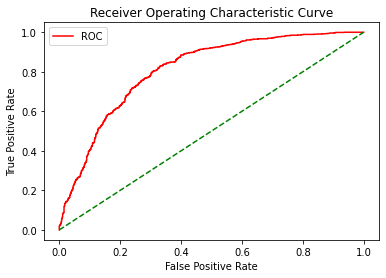

MSP AUROC score: 0.8093788888888889


In [55]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(msp)
print('id mean score:', np.mean(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores))
       
fper, tper, _ = roc_curve(test_y, ood_scores)
auroc_score = roc_auc_score(test_y, ood_scores)

plot_roc_curve(fper, tper)
print('MSP AUROC score:', auroc_score)

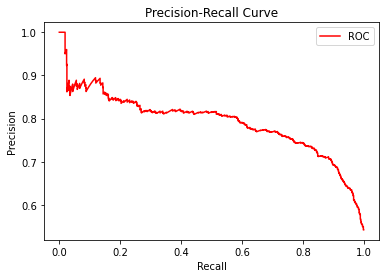

MSP AUPR score: 0.7925079342537422


In [56]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(test_y, ood_scores)
aupr_score = average_precision_score(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('MSP AUPR score:', aupr_score)

### OOD detection by Mahalanobis

In [57]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis

mahalanobis = Mahalanobis(config, model)

Files already downloaded and verified
covariance norm: 22.59798091898979


  0%|          | 0/100 [00:00<?, ?it/s]

processing in-distribution samples...


  0%|          | 2/1000 [00:00<00:50, 19.83it/s]

processing out-of-distribution samples...


100%|██████████| 1000/1000 [01:00<00:00, 16.42it/s]


id mean score: 178.37759356180825
ood mean score: 375.8514508972168


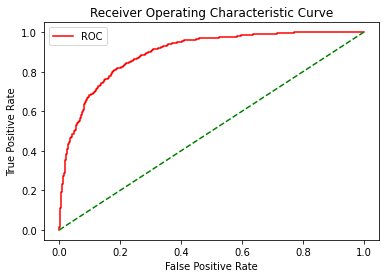

Mahalanobis AUROC score: 0.8946999999999998


In [58]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(mahalanobis)
print('id mean score:', np.mean(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores))
       
fper, tper, _ = roc_curve(test_y, ood_scores)
auroc_score = roc_auc_score(test_y, ood_scores)

plot_roc_curve(fper, tper)
print('Mahalanobis AUROC score:', auroc_score)

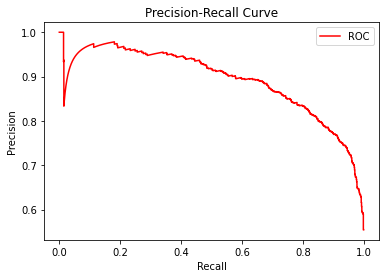

Mahalanobis AUPR score: 0.8922381675156905


In [59]:
precision, recall, _ = precision_recall_curve(test_y, ood_scores)
aupr_score = average_precision_score(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)